# Outreachy Data Science 

### Issue 6

#### Device Failue: Modeling Dataset - Feature Generation

The desire is to try to utilize the telemetry attributes to predict device failure in the field. This requires generating a feature set for use in modeling.

-  What are good features for modeling device failure?
-  How would you choose the best features?


In [1]:
#import libraries for faster performance and easier code.
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import chi2

%matplotlib inline

In [2]:
#load csv and assess data
df = pd.read_csv('../device-failure/device_failure.csv')
df.head()

,date,device,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,failure
0,15001,S1F01085,215630672,56,0,52,6,407438,0,0,7,0
1,15001,S1F0166B,61370680,0,3,0,6,403174,0,0,0,0
2,15001,S1F01E6Y,173295968,0,0,0,12,237394,0,0,0,0
3,15001,S1F01JE0,79694024,0,0,0,6,410186,0,0,0,0
4,15001,S1F01R2B,135970480,0,0,0,15,313173,0,0,3,0


## Assess Data

In [3]:
#length
len(df)

124494

In [4]:
#number of columns
len(df.columns)

12

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
date          124494 non-null int64
device        124494 non-null object
attribute1    124494 non-null int64
attribute2    124494 non-null int64
attribute3    124494 non-null int64
attribute4    124494 non-null int64
attribute5    124494 non-null int64
attribute6    124494 non-null int64
attribute7    124494 non-null int64
attribute8    124494 non-null int64
attribute9    124494 non-null int64
failure       124494 non-null int64
dtypes: int64(11), object(1)
memory usage: 11.4+ MB


This is a relatively clean data set, with no duplicated rows and no empty cells. As a result, data cleaning is not a major task here. We do not know what each attribute is for though, more information on the attributes themselves would make feature selection easier. 

For example:

In [6]:
df.describe()

,date,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,failure
count,124494.000000,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,15106.222798,1.223868e+08,159.484762,9.940455,1.741120,14.222693,260172.858025,0.292528,0.292528,12.451524,0.000851
std,78.412061,7.045960e+07,2179.657730,185.747321,22.908507,15.943021,99151.009852,7.436924,7.436924,191.425623,0.029167
min,15001.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000,0.000000
25%,15040.000000,6.127675e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000,0.000000
50%,15086.000000,1.227957e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000,0.000000,0.000000
75%,15168.000000,1.833084e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000,0.000000
max,15306.000000,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,18701.000000,1.000000


For most of the attributes there is a very large skew where the min value, 25% value, 50% value and 75% value are all 0 but the max is some very large number which distorts the mean and standard deviation. <br>

**Is this a data cleaning issue? <br>
Answer** : We cannot say for sure as we do not now what the attributes are and what they values are supposed to be. As a result these values will not be touched. 
 
However, just by looking at the dataframe, I can see that the date field would be better off if separated which would generate a larger number of features. I am not a big fan of the date being in the integer format as it makes further analysis, such as a group by, a pain

In [7]:
#copy data from original dataframe 
date_df = pd.DataFrame(df['date'])
#date_df.head()
#I am guessing the encoding is year and day of year in integer
date_df['strdate'] = date_df.date.astype(str)
date_df['year'] = date_df['strdate'].str[0:2]
date_df['dayofyear'] = date_df['strdate'].str[2:]
#adding back to the main df 
df.insert(loc=2, column='year', value=date_df['year'])
df.insert(loc=3, column='dayofyear', value=date_df['dayofyear'])

df.head()

,date,device,year,dayofyear,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,failure
0,15001,S1F01085,15,001,215630672,56,0,52,6,407438,0,0,7,0
1,15001,S1F0166B,15,001,61370680,0,3,0,6,403174,0,0,0,0
2,15001,S1F01E6Y,15,001,173295968,0,0,0,12,237394,0,0,0,0
3,15001,S1F01JE0,15,001,79694024,0,0,0,6,410186,0,0,0,0
4,15001,S1F01R2B,15,001,135970480,0,0,0,15,313173,0,0,3,0


## Feature Selection

#### Correlation Matrix

In [8]:
#plot the correlation matrix
corr = df[df.columns[2:]].corr()
corr.style.background_gradient().set_precision(2)

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,failure
attribute1,1,-0.0042,0.0037,0.0018,-0.0034,-0.0015,0.00015,0.00015,0.0011,0.002
attribute2,-0.0042,1,-0.0026,0.15,-0.014,-0.026,0.14,0.14,-0.0027,0.053
attribute3,0.0037,-0.0026,1,0.097,-0.0067,0.009,-0.0019,-0.0019,0.53,-0.00095
attribute4,0.0018,0.15,0.097,1,-0.0098,0.025,0.046,0.046,0.036,0.067
attribute5,-0.0034,-0.014,-0.0067,-0.0098,1,-0.017,-0.0094,-0.0094,0.0059,0.0023
attribute6,-0.0015,-0.026,0.009,0.025,-0.017,1,-0.012,-0.012,0.021,-0.00055
attribute7,0.00015,0.14,-0.0019,0.046,-0.0094,-0.012,1,1,0.0069,0.12
attribute8,0.00015,0.14,-0.0019,0.046,-0.0094,-0.012,1,1,0.0069,0.12
attribute9,0.0011,-0.0027,0.53,0.036,0.0059,0.021,0.0069,0.0069,1,0.0016
failure,0.002,0.053,-0.00095,0.067,0.0023,-0.00055,0.12,0.12,0.0016,1


Another thing to note is the correlation of the attribute 7 and 8. They have a correlation of 1 with each other. There can be 2 possibilities:
-  Either the values are the same in both columns 
-  Or the values of both columns are related to one another. 

We have to select the best features based on the data we have. From the following correlation matrix we can see that attribute2, attribute4, attribute7 and attribute8 are the most important in making an analysis and can be taken as the best features. The advantage of using correlation over covariance is that it is normalised and not dependent on the scales of the column values, though covariance is also an option.

#### Chi Squared Selection

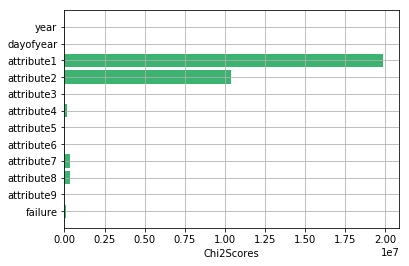

In [9]:
df_new = df.drop(['device','date'], axis=1)
chi2score = chi2(df_new,df_new.failure)[0] #values

#plot results
fig, ax = plt.subplots() 
y_pos = np.arange(len(df_new.columns))
ax.barh(y_pos, chi2score, align='center',color='mediumseagreen', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(df_new.columns)
ax.invert_yaxis()
ax.set_xlabel('Chi2Scores')
plt.grid(True)
plt.show()


From the above figure we can see that attribute1 and attribute2 are the most important for our analysis followed by attributes 7 and 8 who have the same improtance level. 

#### Random Forest

/home/sando/anaconda3/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


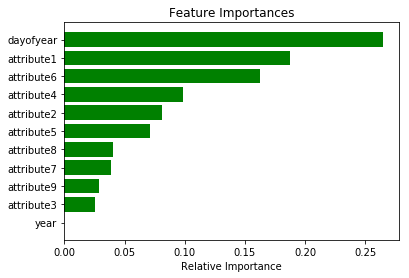

In [10]:
new_df=df.drop(['device','failure','date'], axis=1)
target = df['failure']
model = RandomForestRegressor(random_state=1, max_depth=10)
model.fit(new_df,target)
features = new_df.columns
importances = model.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Day of year becomes the more imporatant variable to be selected, followed by attribute1 and 6. Considering, that the result is a classification problem (where 1 and 0 are the two classes of failure), a random forest regressor would give a precise result

Thus, it can be seen that different filter yield different results. I can perform other analysis to select the best features such as 

1.  Missing Value Filters - which I cannot perform here becasue there are no missing values found.
2.  Linear Discriminant Analysis - which I have not performed becasue the variables are co linear and it would not be the best choice. 